In [2]:
pip install tensorflow matplotlib


Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Load the dataset (example with MNIST)
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

# Create batches and shuffle the data
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [4]:
# Generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

# Discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

generator = make_generator_model()
discriminator = make_discriminator_model()


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# Define loss functions and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


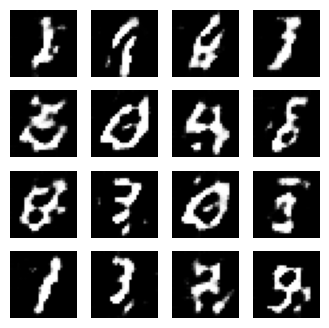

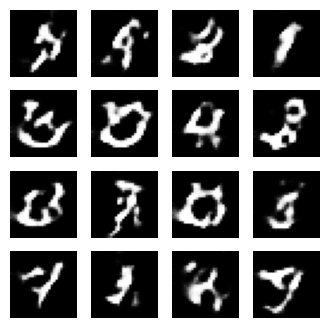

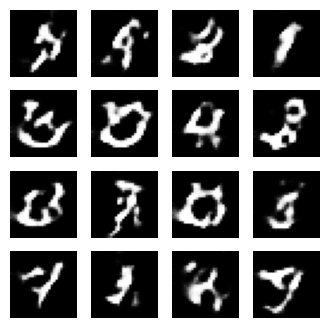

In [9]:
# Training parameters
EPOCHS = 10  # Reduced for quicker iteration
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    gen_loss_list = []
    disc_loss_list = []
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
        
        gen_loss_list.append(gen_loss)
        disc_loss_list.append(disc_loss)
        
        if (epoch + 1) % 5 == 0:
            generate_and_save_images(generator, epoch + 1, seed)

    generate_and_save_images(generator, epochs, seed)
    return gen_loss_list, disc_loss_list

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Train the DCGAN
gen_loss_list, disc_loss_list = train(train_dataset, EPOCHS)


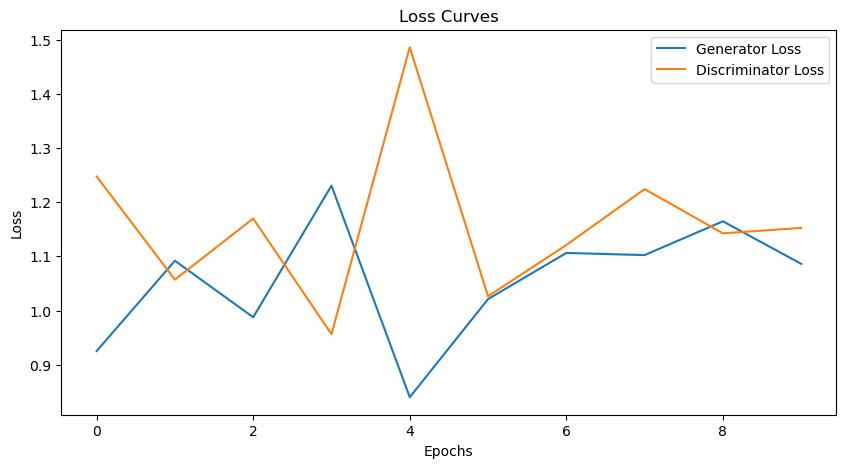

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(gen_loss_list, label='Generator Loss')
plt.plot(disc_loss_list, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()


In [11]:
min_gen_loss = min(gen_loss_list)
min_disc_loss = min(disc_loss_list)

print(f"Minimum Generator Loss: {min_gen_loss}")
print(f"Minimum Discriminator Loss: {min_disc_loss}")


Minimum Generator Loss: 0.8400024175643921
Minimum Discriminator Loss: 0.9563421607017517


In [15]:
def make_enhanced_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 512)))
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    return model

enhanced_generator = make_enhanced_generator_model()


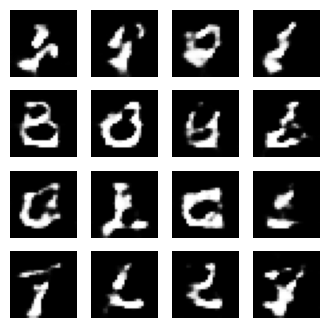

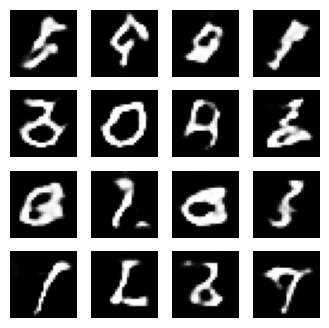

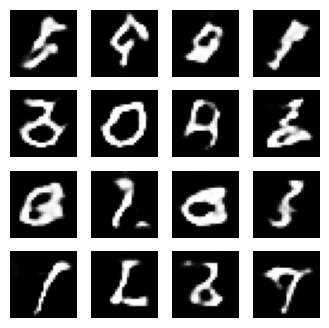

In [16]:
# Train the enhanced DCGAN 
gen_loss_list_enhanced, disc_loss_list_enhanced = train(train_dataset, EPOCHS) 


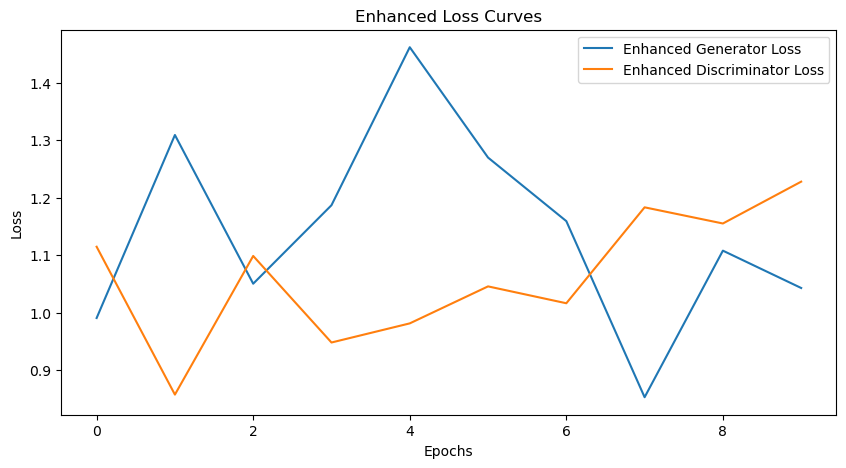

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(gen_loss_list_enhanced, label='Enhanced Generator Loss')
plt.plot(disc_loss_list_enhanced, label='Enhanced Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Enhanced Loss Curves')
plt.show()


In [18]:
min_gen_loss_enhanced = min(gen_loss_list_enhanced)
min_disc_loss_enhanced = min(disc_loss_list_enhanced)

print(f"Minimum Enhanced Generator Loss: {min_gen_loss_enhanced}")
print(f"Minimum Enhanced Discriminator Loss: {min_disc_loss_enhanced}")


Minimum Enhanced Generator Loss: 0.8525891304016113
Minimum Enhanced Discriminator Loss: 0.8571470975875854


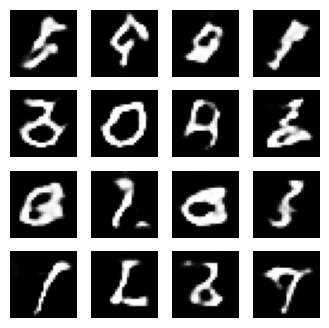

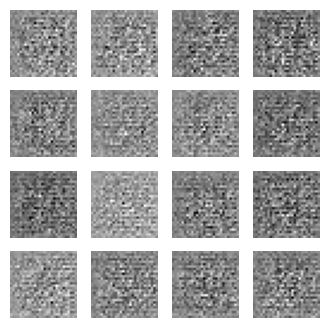

In [19]:
# Generate images from the basic model
generate_and_save_images(generator, EPOCHS, seed)

# Generate images from the enhanced model
generate_and_save_images(enhanced_generator, EPOCHS, seed)
